In [1]:
%load_ext autoreload
%autoreload 2
%env GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/

import sys
import os
import glob

### Custom code
helpers = os.path.abspath('../../../Helpers')
if helpers not in sys.path:
    sys.path.append(helpers)
from utils import (
    mkdir_p,
)
from hydrogen import (
    sherpa_xtbabs_model, 
    generate_tbabs_interp_table,
    get_tbabs_template_model,
)
from gammapy_ogip.ogip_spectrum_dataset import StandardOGIPDataset

from gammapy.modeling.models import (
    SkyModel,
    Models,
    PowerLaw2SpectralModel,
    PowerLawNormSpectralModel,
    FoVBackgroundModel,
)
from gammapy.datasets import Datasets
from gammapy.modeling import Fit

import numpy as np
import astropy.units as u 
import matplotlib.pyplot as plt

from astropy.table import Table
from io import StringIO

env: GAMMAPY_DATA=/home/mnievas/Software/cta/gammapy/gammapy-datasets/


## Instrumental models

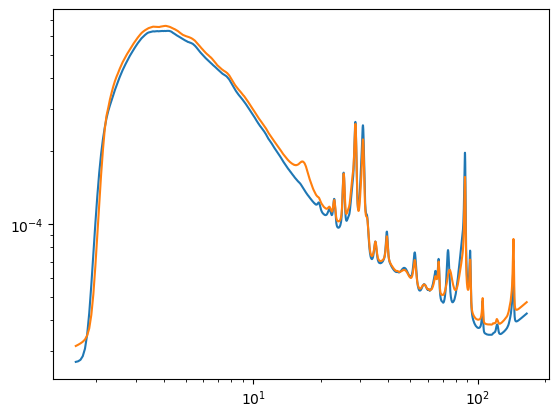

In [2]:
bkgmodels = {}
for model in ['A','B']:
    with open(f"/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/bgd/model_background_{model}.qdp") as f:
        content = '\n'.join([l for l in f.readlines() if l[0]!='@'])
        bkgmodels[model] = Table.read(content,format='ascii.qdp')

plt.plot(
    bkgmodels['A']['col1'],
    bkgmodels['A']['col3']
)
plt.plot(
    bkgmodels['B']['col1'],
    bkgmodels['B']['col3']
)
plt.yscale('log')
plt.xscale('log')

In [3]:
def prepare_dataset(phafile,background,name='OGIP',energy_downsample=32):
    MyOGIP = StandardOGIPDataset.read(phafile)
    SDataset = MyOGIP.to_spectrum_dataset_onoff(name=name)
    SDataset_src = SDataset.to_spectrum_dataset().copy()
    SDataset_src.counts = SDataset.counts.copy()
    # from Fabio
    #SDataset_src.background.data = np.genfromtxt(background,skip_header=3)[:,4]*0.8e3
    # Mine
    with open(background) as f:
        content = '\n'.join([l for l in f.readlines() if l[0]!='@'])
        bkgmodeltable = Table.read(content,format='ascii.qdp')#, table_id=1)
        SDataset_src.background.data = np.asarray(bkgmodeltable['col3'])
    
    # Resample datasets
    if energy_downsample!=1:
        SDataset = SDataset.downsample(energy_downsample,'energy')
        SDataset_src = SDataset_src.downsample(energy_downsample,'energy')

    SDataset._name = name
    SDataset_src._name = name
    
    SDataset.meta_table = None
    SDataset_src.meta_table = None
    return({'phafile':phafile, 'background':background, 'wstat': SDataset, 'cstat': SDataset_src})

NuSTAR_A = prepare_dataset(
    #phafile="/mnt/sdb1/Nustar/OP313_FromFabio/91002609004/nu91002609004A01_sr.pha",
    #background="/mnt/sdb1/Nustar/OP313_FromFabio/91002609004/bkgA-only-norebin-4096chan.qdp",
    phafile="/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/products/nu91002609004A01_sr.pha",
    background="/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/bgd/model_background_A.qdp",
    name="NuSTAR_A",
)
NuSTAR_B = prepare_dataset(
    #phafile="/mnt/sdb1/Nustar/OP313_FromFabio/91002609004/nu91002609004A01_sr.pha",
    #background="/mnt/sdb1/Nustar/OP313_FromFabio/91002609004/bkgB-only-norebin-4096chan.qdp",
    phafile="/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/products/nu91002609004B01_sr.pha",
    background="/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/bgd/model_background_B.qdp",
    name="NuSTAR_B",
)

NuSTAR_A_modelbkg = NuSTAR_A['cstat']
NuSTAR_B_modelbkg = NuSTAR_B['cstat']

NuSTAR_A_wstatbkg = NuSTAR_A['wstat']
NuSTAR_B_wstatbkg = NuSTAR_B['wstat']

/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/mnievas/anaconda/envs/ciaoxray_devel/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [4]:
### Sky models

def generate_instrumental_background(dataset_name):
    Norm_InstBackground = PowerLawNormSpectralModel()
    Norm_InstBackground.tilt.frozen = True
    Norm_InstBackground.norm.frozen = False
    Norm_InstBackground.reference.frozen = True
    Norm_InstBackground.reference.value  = 1
    Norm_InstBackground.reference.unit   = 'keV'
    return(FoVBackgroundModel(
        spectral_model=Norm_InstBackground,
        dataset_name=dataset_name))

def get_1d_pwl_skymodel(name):
    s = PowerLaw2SpectralModel()
    s.emin.value = 3
    s.emin.unit  = 'keV'
    s.emax.value = 70
    s.emax.unit  = 'keV'
    s.amplitude.value = 1e-4
    s.amplitude.unit = 's-1 cm-2'
    s.amplitude.min  = 1e-9
    s.amplitude.max  = 1e6
    s.index.value = 2
    s.index.min  = -2.0
    s.index.max  = 8.0
    skymodel = SkyModel(name=name, spectral_model=s)
    return(skymodel)

# Source (pwl)
OP313_SkyModel = get_1d_pwl_skymodel(name='OP313')

### Full model, with instrumental background
NuSTAR_A_modelbkg.models = Models([OP313_SkyModel]) + generate_instrumental_background(NuSTAR_A_modelbkg.name)
NuSTAR_B_modelbkg.models = Models([OP313_SkyModel]) + generate_instrumental_background(NuSTAR_B_modelbkg.name)

### Full model, with instrumental background
NuSTAR_A_wstatbkg.models = Models([OP313_SkyModel])
NuSTAR_B_wstatbkg.models = Models([OP313_SkyModel])

In [5]:
# Prefit
nustar_only_fit    = Fit(store_trace=True)
nustar_only_result = nustar_only_fit.run([NuSTAR_A_modelbkg,NuSTAR_B_modelbkg])

norm_bkg_A = float(NuSTAR_A_modelbkg.models['NuSTAR_A-bkg'].spectral_model.norm.value)
norm_bkg_B = float(NuSTAR_B_modelbkg.models['NuSTAR_B-bkg'].spectral_model.norm.value)
NuSTAR_A_modelbkg.models['NuSTAR_A-bkg'].spectral_model.norm.value = 1
NuSTAR_B_modelbkg.models['NuSTAR_B-bkg'].spectral_model.norm.value = 1

In [6]:
# Save and compress the datasets
basedir = os.path.abspath("../../../")
outdir  = f"{basedir}/NuSTAR/MJD60384/"
mkdir_p(outdir)
for g in glob.glob(f"{outdir}/*.yaml*"): os.remove(g)
for g in glob.glob(f"{outdir}/*.fits*"): os.remove(g)

NuSTAR_dataset = Datasets([NuSTAR_A_modelbkg,NuSTAR_B_modelbkg])

NuSTAR_dataset.write(filename=f"{outdir}/dataset.yaml",
              filename_models=f"{outdir}/models.yaml",
              write_covariance=False,
              overwrite=True)

!gzip {outdir}/NuSTAR_A.fits
!gzip {outdir}/NuSTAR_B.fits
!sed -i 's/NuSTAR_A.fits/NuSTAR_A.fits.gz/g' {outdir}/dataset.yaml
!sed -i 's/NuSTAR_B.fits/NuSTAR_B.fits.gz/g' {outdir}/dataset.yaml

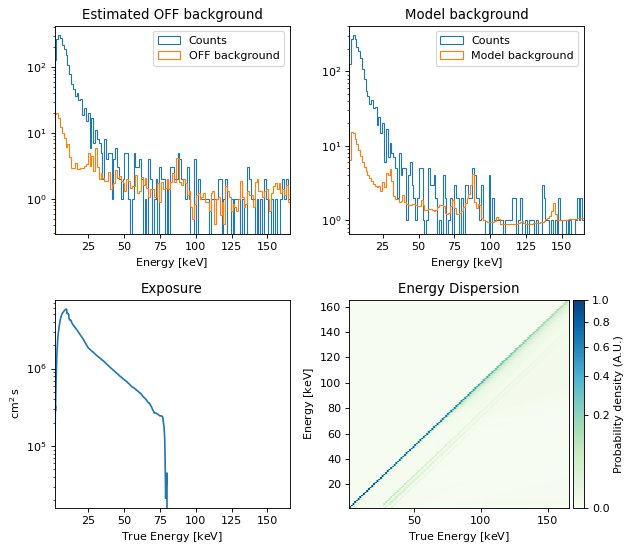

In [7]:
fig, axs = plt.subplots(2,2,figsize=(8,7),dpi=80)

axs[0][0].set_title("Estimated OFF background")
NuSTAR_A['wstat'].plot_counts(axs[0][0], kwargs_background={'label': 'OFF background'})
axs[0][0].legend()

axs[0][1].set_title("Model background")
bkgdata = NuSTAR_A['cstat'].background.data.copy()
NuSTAR_A['cstat'].background.data *= norm_bkg_A
NuSTAR_A['cstat'].plot_counts(axs[0][1], kwargs_background={'label': 'Model background'})
axs[0][1].legend()
NuSTAR_A['cstat'].background.data = bkgdata

axs[1][0].set_title("Exposure")
NuSTAR_A['cstat'].exposure.plot(axs[1][0], ls="-", markersize=0, xerr=None)

axs[1][1].set_title("Energy Dispersion")

if NuSTAR_A['cstat'].edisp is not None:
    kernel = NuSTAR_A['cstat'].edisp.get_edisp_kernel()
    kernel.plot_matrix(ax=axs[1][1], add_cbar=True)

axs[1][1].set_rasterized(True)
plt.tight_layout()
!mkdir -p {basedir}/Figures/MJD60384/NuSTAR/
fig.savefig(f'{basedir}/Figures/MJD60384/NuSTAR/NuSTAR_A_rebinned_IRFs.pdf')


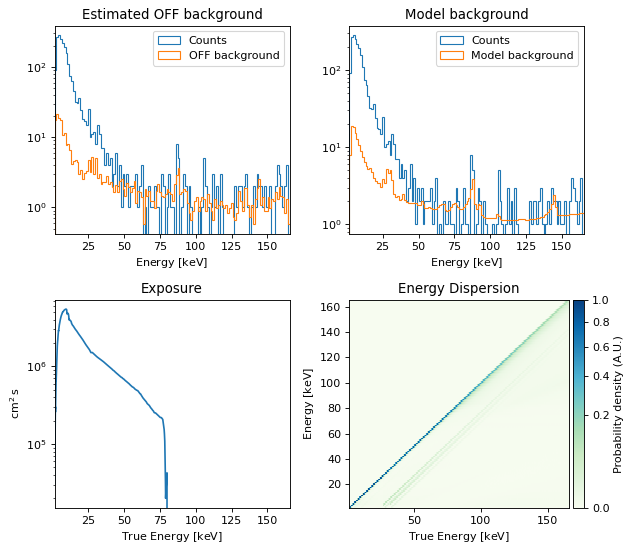

In [8]:
fig, axs = plt.subplots(2,2,figsize=(8,7),dpi=80)

axs[0][0].set_title("Estimated OFF background")
NuSTAR_B['wstat'].plot_counts(axs[0][0], kwargs_background={'label': 'OFF background'})
axs[0][0].legend()

axs[0][1].set_title("Model background")
bkgdata = NuSTAR_B['cstat'].background.data.copy()
NuSTAR_B['cstat'].background.data *= norm_bkg_B
NuSTAR_B['cstat'].plot_counts(axs[0][1], kwargs_background={'label': 'Model background'})
axs[0][1].legend()
NuSTAR_B['cstat'].background.data = bkgdata

axs[1][0].set_title("Exposure")
NuSTAR_B['cstat'].exposure.plot(axs[1][0], ls="-", markersize=0, xerr=None)

axs[1][1].set_title("Energy Dispersion")

if NuSTAR_B['cstat'].edisp is not None:
    kernel = NuSTAR_B['cstat'].edisp.get_edisp_kernel()
    kernel.plot_matrix(ax=axs[1][1], add_cbar=True)

axs[1][1].set_rasterized(True)
plt.tight_layout()
!mkdir -p {basedir}/Figures/MJD60384/NuSTAR/
fig.savefig(f'{basedir}/Figures/MJD60384/NuSTAR/NuSTAR_B_rebinned_IRFs.pdf')


### Export also the wstat background

In [9]:
# Prefit
nustar_only_fit    = Fit(store_trace=True)
nustar_only_result = nustar_only_fit.run([NuSTAR_A_wstatbkg,NuSTAR_B_wstatbkg])

In [10]:
# Save and compress the datasets
basedir = os.path.abspath("../../../")
outdir  = f"{basedir}/NuSTAR/MJD60384/wstat_background"
mkdir_p(outdir)
for g in glob.glob(f"{outdir}/*.yaml*"): os.remove(g)
for g in glob.glob(f"{outdir}/*.fits*"): os.remove(g)

NuSTAR_dataset = Datasets([NuSTAR_A_wstatbkg,NuSTAR_B_wstatbkg])

NuSTAR_dataset.write(filename=f"{outdir}/dataset.yaml",
              filename_models=f"{outdir}/models.yaml",
              write_covariance=False,
              overwrite=True)

## ON/OFF Region plots

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 60384.219549 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 60384.219549 from DATE-END'. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Invalid parameter values: MJD-OBS and DATE-OBS are inconsistent.
Set MJD-END to 60384.219549 from DATE-END'. [astropy.wcs.wcs]


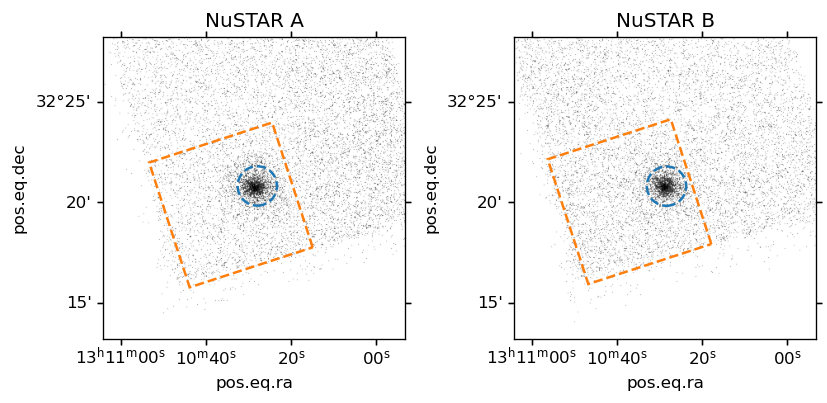

In [13]:
import regions
import matplotlib as mpl
import matplotlib.colors as mcolors 
from astropy.io import fits as pyfits
from astropy.visualization import AsinhStretch, PercentileInterval
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter

nustar_image_files = sorted(glob.glob("/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/nu91002609004*01_sk.img"))
nustar_hdus = [pyfits.open(f)[0] for f in nustar_image_files]

# Get the colormap colors
my_cmap = mpl.cm.Greys(np.arange(mpl.cm.Greys.N))
# Set alpha
my_cmap[0,-1] = 0
my_cmap = mcolors.ListedColormap(my_cmap)

fig = plt.figure(figsize=(7,4),dpi=120)

transform1 = AsinhStretch() + PercentileInterval(1)#99.975)
transform2 = AsinhStretch() + PercentileInterval(99.975)



cutoutdata = Cutout2D(nustar_hdus[0].data, position=SkyCoord.from_name('OP313'), 
                      size=15*u.arcmin, wcs=WCS(nustar_hdus[0]))

ax = fig.add_subplot(121, projection=cutoutdata.wcs)
ax.imshow(gaussian_filter(transform2(cutoutdata.data),0),cmap=my_cmap)
ax.imshow(gaussian_filter(transform1(cutoutdata.data),0.5),alpha=0.5,cmap=my_cmap)

reghdus = pyfits.open("/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/spec/src1A_sr.pha")
r = regions.CirclePixelRegion(
    center=regions.PixCoord(reghdus[3].data['X'][0][0],reghdus[3].data['Y'][0][0]),
    radius=reghdus[3].data['R'][0][0]
)
r.to_sky(WCS(nustar_hdus[0].header)).to_pixel(cutoutdata.wcs).plot(
    lw=1.5,color='C0',ls='dashed',label='Source region')

reghdus = pyfits.open("/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/bgd/bgd1A_sr.pha")
roff = regions.RectanglePixelRegion(
    center=regions.PixCoord(reghdus[3].data['X'][0][0],reghdus[3].data['Y'][0][0]),
    width=reghdus[3].data['R'][0][0],
    height=reghdus[3].data['R'][0][1],
    angle=reghdus[3].data['ROTANG'][0][0]*u.deg,
)
roff.to_sky(WCS(nustar_hdus[0].header)).to_pixel(cutoutdata.wcs).plot(
    lw=1.5,color='C1',ls='dashed',label='Background region')

ax.set_title('NuSTAR A')
ax.set_box_aspect(1)




cutoutdata = Cutout2D(nustar_hdus[1].data, position=SkyCoord.from_name('OP313'), 
                      size=15*u.arcmin, wcs=WCS(nustar_hdus[1]))

ax.coords['ra'].set_ticks(number=4,direction='out')

ax = fig.add_subplot(122, projection=cutoutdata.wcs)
ax.imshow(gaussian_filter(transform2(cutoutdata.data),0),cmap=my_cmap)
ax.imshow(gaussian_filter(transform1(cutoutdata.data),0.5),alpha=0.5,cmap=my_cmap)

reghdus = pyfits.open("/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/spec/src1B_sr.pha")
r = regions.CirclePixelRegion(
    center=regions.PixCoord(reghdus[3].data['X'][0][0],reghdus[3].data['Y'][0][0]),
    radius=reghdus[3].data['R'][0][0]
)
r.to_sky(WCS(nustar_hdus[1].header)).to_pixel(cutoutdata.wcs).plot(
    lw=1.5,color='C0',ls='dashed',label='Source region')

reghdus = pyfits.open("/mnt/sdb1/Nustar/OP313_ModelBackground/91002609004/event_cl/bgd/bgd1B_sr.pha")
roff = regions.RectanglePixelRegion(
    center=regions.PixCoord(reghdus[3].data['X'][0][0],reghdus[3].data['Y'][0][0]),
    width=reghdus[3].data['R'][0][0],
    height=reghdus[3].data['R'][0][1],
    angle=reghdus[3].data['ROTANG'][0][0]*u.deg,
)
roff.to_sky(WCS(nustar_hdus[1].header)).to_pixel(cutoutdata.wcs).plot(
    lw=1.5,color='C1',ls='dashed',label='Background region')

ax.set_title('NuSTAR B')
ax.set_box_aspect(1)
ax.coords['ra'].set_ticks(number=4,direction='out')
plt.tight_layout()

!mkdir -p {basedir}/Figures/MJD60384/
fig.savefig(f'{basedir}/Figures/MJD60384/NuSTAR/NuSTAR_91002609004_OP313.pdf',bbox_inches='tight')